In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import seaborn as sns
from wordcloud import WordCloud
from collections import Counter


import time
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import scale
from sklearn.manifold import TSNE
from sklearn.impute import SimpleImputer

from scipy.stats import pearsonr, chi2_contingency
from itertools import combinations
sales_df = pd.read_csv('./sales_data.csv')
member_df = pd.read_csv('./member_data.csv')
product_df = pd.read_csv('./product_data.csv')

In [2]:

from datetime import datetime
def convert_to_24hr(time_str):
    try:
        period, time = time_str.split()
        hour, minute = map(int, time.split(':'))
        if period == '오후' and hour != 12:
            hour += 12
        elif period == '오전' and hour == 12:
            hour = 0
        
        if minute >= 60:
            hour += minute // 60
            minute %= 60

        if hour >= 24:
            hour %= 24
        
        time_24hr = f'{hour:02}:{minute:02}'

        if time_24hr == '24:00':
            return '잘못된 형식'

        return time_24hr
    except ValueError:
        return '잘못된 형식'

In [4]:
# 파생변수 
# 가장 최근 구매일로부터 며칠 전인가? : recency
# 총 몇번 구매 하였는가 ? : 회원별 order count = orderId    -> freq
# 고객이 구입했던 총 금액은 얼마인가 ? : Monetary
import dataclean as dc

sales_df['주문시간_24'] = sales_df['주문시간'].apply(dc.convert_to_24hr)
#sales_df['주문일시'] = pd.to_datetime(sales_df['주문일시'])
sales_df['주문일시_c'] = sales_df['주문일시'] + ' ' + sales_df['주문시간_24']

sales_df['주문일시_c'] = pd.to_datetime(sales_df['주문일시_c'])

In [7]:
#가장 최근 구매일로부터 얼마전 구매? D
latestdate = np.max(sales_df['주문일시_c'])
print(latestdate)
sales_df['recency'] = sales_df['주문일시_c'].apply(lambda x: (latestdate - x).days)

2022-11-06 23:58:00


In [8]:
#총 몇번 구매?
sales_df.sort_values(by=['회원번호', '주문일시_c'], inplace=True)
sales_df['회원번호별주문순번'] = sales_df.groupby('회원번호').cumcount() + 1



In [10]:
rfm_Df = sales_df.groupby('회원번호')['구매금액'].sum().reset_index()
rfm_Df

,회원번호,구매금액
0,18764160,811902
1,18792000,9955
2,18942336,1418288
3,18949760,35130
4,19391488,3159
...,...,...
12535,1644957952,54944
12536,1645334720,52647
12537,1670400000,35670095
12538,1670606016,499949


In [11]:
latest_datess = sales_df.groupby('회원번호')['주문일시_c'].idxmax()

# 가장 최근의 주문일시를 가진 행들만 필터링
latest_orders_df = sales_df.loc[latest_datess]

In [13]:
merged_df = pd.merge(rfm_Df, latest_orders_df, on='회원번호')

rfm_df_r = merged_df[['회원번호', 'recency', '구매금액_x', '회원번호별주문순번']]

In [14]:

pd.set_option('display.float_format', '{:.2f}'.format)
rfm_df_r.describe()

,회원번호,recency,구매금액_x,회원번호별주문순번
count,12540.00,12540.00,12540.00,12540.00
mean,818856651.14,70.61,629855.32,51.36
std,441242841.98,83.37,1252151.56,97.87
min,18764160.00,0.00,766.00,1.00
25%,462398272.00,7.00,53508.75,2.00
50%,775869248.00,31.00,189699.00,14.00
75%,1174002592.00,114.00,665855.50,57.00
max,1670620864.00,302.00,35670095.00,3111.00


In [16]:
quintiles = rfm_df_r[['recency', '회원번호별주문순번', '구매금액_x']].quantile([.2, .4, .6, .8]).to_dict()
quintiles

{'recency': {0.2: 5.0, 0.4: 18.0, 0.6: 52.0, 0.8: 142.0},
 '회원번호별주문순번': {0.2: 1.0, 0.4: 8.0, 0.6: 25.0, 0.8: 76.0},
 '구매금액_x': {0.2: 40490.0,
  0.4: 115293.60000000003,
  0.6: 308419.0,
  0.8: 874027.4000000007}}

In [17]:
def r_score(x): #최근주문 점수 up
    if x <= quintiles['recency'][.2]:
        return 5
    elif x <= quintiles['recency'][.4]:
        return 4
    elif x <= quintiles['recency'][.6]:
        return 3
    elif x <= quintiles['recency'][.8]:
        return 2
    else:
        return 1
    
def fm_score(x, c): #빈도, 구매금액
    if x <= quintiles[c][.2]:
        return 1
    elif x <= quintiles[c][.4]:
        return 2
    elif x <= quintiles[c][.6]:
        return 3
    elif x <= quintiles[c][.8]:
        return 4
    else:
        return 5    

In [18]:
rfm_df_r['R'] = rfm_df_r['recency'].apply(lambda x: r_score(x))
rfm_df_r['F'] = rfm_df_r['회원번호별주문순번'].apply(lambda x: fm_score(x, '회원번호별주문순번'))
rfm_df_r['M'] = rfm_df_r['구매금액_x'].apply(lambda x: fm_score(x, '구매금액_x'))

C:\Users\campus4D029\AppData\Local\Temp\ipykernel_21460\4261628068.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_df_r['R'] = rfm_df_r['recency'].apply(lambda x: r_score(x))
C:\Users\campus4D029\AppData\Local\Temp\ipykernel_21460\4261628068.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_df_r['F'] = rfm_df_r['회원번호별주문순번'].apply(lambda x: fm_score(x, '회원번호별주문순번'))
C:\Users\campus4D029\AppData\Local\Temp\ipykernel_21460\4261628068.py:3: SettingWithCopyWarning: 
A value is trying to be set on a

In [19]:
rfm_df_r['RFM_Score'] = rfm_df_r['R'].map(str) + rfm_df_r['F'].map(str) + rfm_df_r['M'].map(str)
rfm_df_r.head()

C:\Users\campus4D029\AppData\Local\Temp\ipykernel_21460\523948856.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_df_r['RFM_Score'] = rfm_df_r['R'].map(str) + rfm_df_r['F'].map(str) + rfm_df_r['M'].map(str)


,회원번호,recency,구매금액_x,회원번호별주문순번,R,F,M,RFM_Score
0,18764160,25,811902,33,3,4,4,344
1,18792000,209,9955,1,1,1,1,111
2,18942336,11,1418288,79,4,5,5,455
3,18949760,31,35130,1,3,1,1,311
4,19391488,165,3159,1,1,1,1,111


In [20]:
segt_map = {
    r'[1-2][1-2]': '최근구매없음/구매횟수적음',
    r'[1-2][3-4]': '최근구매없음/구매횟수보통',
    r'[1-2]5': '최근구매없음/구매횟수많음',
    r'3[1-2]': '비교적최근구매함/구매횟수적음',
    r'33': '비교적최근구매함/구매횟수보통',
    r'[3-4][4-5]': '최근구매함/구매횟수많음',
    r'41': '최근구매함/구매횟수적음',
    r'51': '방금전구매함/구매횟수적음',
    r'[4-5][2-3]': '방금전구매함/구매횟수보통/프로모션대상',
    r'5[4-5]': '방금전구매함/구매횟수많음'
}

rfm_df_r['Segment'] = rfm_df_r['R'].map(str) + rfm_df_r['F'].map(str)
rfm_df_r['Segment'] = rfm_df_r['Segment'].replace(segt_map, regex=True)
rfm_df_r.head()



C:\Users\campus4D029\AppData\Local\Temp\ipykernel_21460\746465560.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_df_r['Segment'] = rfm_df_r['R'].map(str) + rfm_df_r['F'].map(str)
C:\Users\campus4D029\AppData\Local\Temp\ipykernel_21460\746465560.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_df_r['Segment'] = rfm_df_r['Segment'].replace(segt_map, regex=True)


,회원번호,recency,구매금액_x,회원번호별주문순번,R,F,M,RFM_Score,Segment
0,18764160,25,811902,33,3,4,4,344,최근구매함/구매횟수많음
1,18792000,209,9955,1,1,1,1,111,최근구매없음/구매횟수적음
2,18942336,11,1418288,79,4,5,5,455,최근구매함/구매횟수많음
3,18949760,31,35130,1,3,1,1,311,비교적최근구매함/구매횟수적음
4,19391488,165,3159,1,1,1,1,111,최근구매없음/구매횟수적음


In [21]:
money_5 = (rfm_df_r['M'] == 5) 
money_4 = (rfm_df_r['M'] == 4)
money_3 = (rfm_df_r['M'] == 3)
money_2 = (rfm_df_r['M'] == 2)
money_1 = (rfm_df_r['M'] == 1)

# 총구매금액조건 만족, 방금전구매함/구매횟수많음  이전등급 현재등급 동일
#이전등급 컬럼 : S, 현재등급 컬럼 : S, 이탈컬럼 False
cond1 = rfm_df_r.loc[rfm_df_r['Segment'].isin(['방금전구매함/구매횟수많음']) & (money_5)]  # 1460  S
cond2 = rfm_df_r.loc[rfm_df_r['Segment'].isin(['방금전구매함/구매횟수많음']) & (money_4)]         # 660   A
cond3 = rfm_df_r.loc[rfm_df_r['Segment'].isin(['방금전구매함/구매횟수많음']) & (money_3)]         # 65   B
cond4 = rfm_df_r.loc[rfm_df_r['Segment'].isin(['방금전구매함/구매횟수많음']) & (money_2)]         # 0
cond5 = rfm_df_r.loc[rfm_df_r['Segment'].isin(['방금전구매함/구매횟수많음']) & (money_1)]         # 0

rfm_df_r.loc[rfm_df_r['Segment'].isin(['방금전구매함/구매횟수많음']) & (money_4)]

,회원번호,recency,구매금액_x,회원번호별주문순번,R,F,M,RFM_Score,Segment
16,22259008,1,318557,32,5,4,4,544,방금전구매함/구매횟수많음
80,42307520,0,737875,73,5,4,4,544,방금전구매함/구매횟수많음
166,54078272,1,844733,92,5,5,4,554,방금전구매함/구매횟수많음
203,57272448,4,719635,61,5,4,4,544,방금전구매함/구매횟수많음
224,59516352,0,639128,30,5,4,4,544,방금전구매함/구매횟수많음
...,...,...,...,...,...,...,...,...,...
12430,1626344128,2,352040,43,5,4,4,544,방금전구매함/구매횟수많음
12461,1631821184,1,400117,29,5,4,4,544,방금전구매함/구매횟수많음
12465,1632578432,0,332347,26,5,4,4,544,방금전구매함/구매횟수많음
12467,1632747328,1,370266,30,5,4,4,544,방금전구매함/구매횟수많음


In [22]:
rfm_df_r.loc[rfm_df_r['Segment'].isin(['최근구매없음/구매횟수보통']) & (money_1) , '현재등급'] = 1

# 방금전구매함/구매횟수보통 
rfm_df_r.loc[rfm_df_r['Segment'].isin(['방금전구매함/구매횟수보통']) & (money_5)] # 2     S
rfm_df_r.loc[rfm_df_r['Segment'].isin(['방금전구매함/구매횟수보통']) & (money_4)] # 148   A
rfm_df_r.loc[rfm_df_r['Segment'].isin(['방금전구매함/구매횟수보통']) & (money_3)] # 627   B
rfm_df_r.loc[rfm_df_r['Segment'].isin(['방금전구매함/구매횟수보통']) & (money_2)] # 364  
rfm_df_r.loc[rfm_df_r['Segment'].isin(['방금전구매함/구매횟수보통']) & (money_1)] # 74


C:\Users\campus4D029\AppData\Local\Temp\ipykernel_21460\1078373936.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rfm_df_r.loc[rfm_df_r['Segment'].isin(['최근구매없음/구매횟수보통']) & (money_1) , '현재등급'] = 1


,회원번호,recency,구매금액_x,회원번호별주문순번,R,F,M,RFM_Score,Segment,현재등급


In [24]:
# 방금전구매함/구매횟수적음
rfm_df_r.loc[rfm_df_r['Segment'].isin(['방금전구매함/구매횟수적음']) & (money_5)] # 0
rfm_df_r.loc[rfm_df_r['Segment'].isin(['방금전구매함/구매횟수적음']) & (money_4)] # 0 
rfm_df_r.loc[rfm_df_r['Segment'].isin(['방금전구매함/구매횟수적음']) & (money_3)] # 7    B
rfm_df_r.loc[rfm_df_r['Segment'].isin(['방금전구매함/구매횟수적음']) & (money_2)] # 18
rfm_df_r.loc[rfm_df_r['Segment'].isin(['방금전구매함/구매횟수적음']) & (money_1)].head() # 33

,회원번호,recency,구매금액_x,회원번호별주문순번,R,F,M,RFM_Score,Segment,현재등급
343,69457088,4,4977,1,5,1,1,511,방금전구매함/구매횟수적음,NaN
524,96714304,0,36374,1,5,1,1,511,방금전구매함/구매횟수적음,NaN
698,123084352,1,14358,1,5,1,1,511,방금전구매함/구매횟수적음,NaN
827,141896768,0,23356,1,5,1,1,511,방금전구매함/구매횟수적음,NaN
2926,435603200,0,7466,1,5,1,1,511,방금전구매함/구매횟수적음,NaN


In [25]:
#최근구매함/구매횟수많음
rfm_df_r.loc[rfm_df_r['Segment'].isin(['최근구매함/구매횟수많음']) & (money_5)]  #965  S
rfm_df_r.loc[rfm_df_r['Segment'].isin(['최근구매함/구매횟수많음']) & (money_4)]  #1195 A
rfm_df_r.loc[rfm_df_r['Segment'].isin(['최근구매함/구매횟수많음']) & (money_3)]  #230  B
rfm_df_r.loc[rfm_df_r['Segment'].isin(['최근구매함/구매횟수많음']) & (money_2)]  #1
rfm_df_r.loc[rfm_df_r['Segment'].isin(['최근구매함/구매횟수많음']) & (money_1)]  #0


,회원번호,recency,구매금액_x,회원번호별주문순번,R,F,M,RFM_Score,Segment,현재등급


In [26]:
#최근구매함/구매횟수적음
rfm_df_r.loc[rfm_df_r['Segment'].isin(["최근구매함/구매횟수적음"]) & money_5] # 0
rfm_df_r.loc[rfm_df_r['Segment'].isin(["최근구매함/구매횟수적음"]) & money_4] # 1 A
rfm_df_r.loc[rfm_df_r['Segment'].isin(["최근구매함/구매횟수적음"]) & money_3] # 5 B
rfm_df_r.loc[rfm_df_r['Segment'].isin(["최근구매함/구매횟수적음"]) & money_2] # 48
rfm_df_r.loc[rfm_df_r['Segment'].isin(["최근구매함/구매횟수적음"]) & money_1] # 115


,회원번호,recency,구매금액_x,회원번호별주문순번,R,F,M,RFM_Score,Segment,현재등급
214,58256128,7,19718,1,4,1,1,411,최근구매함/구매횟수적음,NaN
305,65906560,12,18378,1,4,1,1,411,최근구매함/구매횟수적음,NaN
319,67202048,12,34937,1,4,1,1,411,최근구매함/구매횟수적음,NaN
374,73258176,15,6126,1,4,1,1,411,최근구매함/구매횟수적음,NaN
402,76968320,13,11869,1,4,1,1,411,최근구매함/구매횟수적음,NaN
...,...,...,...,...,...,...,...,...,...,...
12513,1640791232,7,15507,1,4,1,1,411,최근구매함/구매횟수적음,NaN
12514,1640902592,15,4307,1,4,1,1,411,최근구매함/구매횟수적음,NaN
12523,1642567424,8,17995,1,4,1,1,411,최근구매함/구매횟수적음,NaN
12525,1643337664,7,10146,1,4,1,1,411,최근구매함/구매횟수적음,NaN


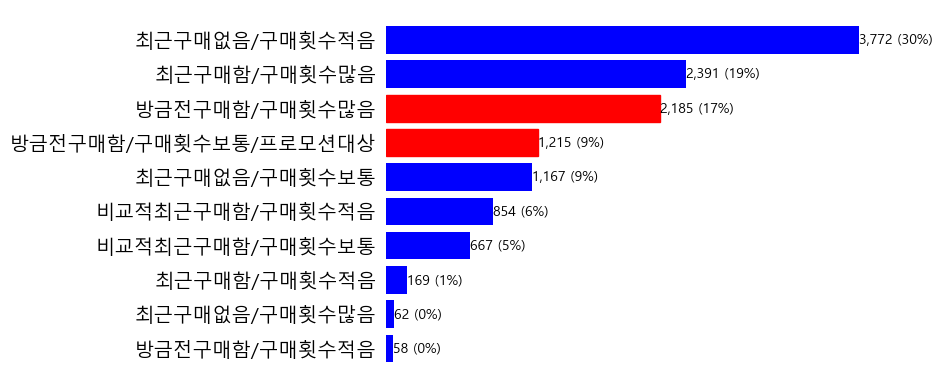

In [27]:


plt.rcParams['font.family'] ='Malgun Gothic'
plt.rcParams['axes.unicode_minus'] =False

segments_counts = rfm_df_r['Segment'].value_counts().sort_values(ascending=True)

fig, ax = plt.subplots()

bars = ax.barh(range(len(segments_counts)),
              segments_counts,
              color='b')

ax.set_frame_on(False)
ax.tick_params(left=False,
               bottom=False,
               labelbottom=False)

ax.set_yticks(range(len(segments_counts)))
ax.set_yticklabels(segments_counts.index,  fontsize = 14)

for i, bar in enumerate(bars):
        value = bar.get_width()
        if segments_counts.index[i] in ['방금전구매함/구매횟수보통/프로모션대상', '방금전구매함/구매횟수많음']:
            bar.set_color('r')
        ax.text(value,
                bar.get_y() + bar.get_height()/2,
                '{:,} ({:}%)'.format(int(value),
                                   int(value*100/segments_counts.sum())),
                va='center',
                ha='left'
               )
sns.set(rc={'figure.figsize':(5,10)})
plt.show()

In [28]:
mem_df = pd.merge(member_df, rfm_df_r, on='회원번호', how='inner')

In [29]:

rfm_df = pd.read_csv('member_RFM.csv')

def calculate_rfm_scores(data):
    # Calculate quantiles for R, F, M
    quantiles = data[['recency', 'frequency', '회원별총구매금액']].quantile([0.2, 0.4, 0.6, 0.8]).to_dict()

    # R score
    data['R'] = data['recency'].apply(lambda x: 5 if x <= quantiles['recency'][0.2] else
                                                 4 if x <= quantiles['recency'][0.4] else
                                                 3 if x <= quantiles['recency'][0.6] else
                                                 2 if x <= quantiles['recency'][0.8] else 1)
    
    # F score
    data['F'] = data['frequency'].apply(lambda x: 1 if x <= quantiles['frequency'][0.2] else
                                                 2 if x <= quantiles['frequency'][0.4] else
                                                 3 if x <= quantiles['frequency'][0.6] else
                                                 4 if x <= quantiles['frequency'][0.8] else 5)
    
    # M score
    data['M'] = data['회원별총구매금액'].apply(lambda x: 1 if x <= quantiles['회원별총구매금액'][0.2] else
                                                     2 if x <= quantiles['회원별총구매금액'][0.4] else
                                                     3 if x <= quantiles['회원별총구매금액'][0.6] else
                                                     4 if x <= quantiles['회원별총구매금액'][0.8] else 5)
    
    #  RFM score
    data['RFM_Score'] = data['M'] * 100 + data['R'] * 10 + data['F']
    
    return data

rfm_data_new = calculate_rfm_scores(rfm_df)
top_10_percent_threshold_new = rfm_data_new['RFM_Score'].quantile(0.9)  # 상위 10% vip 부여
rfm_data_new['VIP'] = rfm_data_new['RFM_Score'] >= top_10_percent_threshold_new

In [32]:
rfm_data_new[rfm_data_new['VIP']]

,Unnamed: 0,회원번호,회원상태,성별,나이,등록카드,결혼,구독여부,주소지,세부주소지,...,frequency,R,F,M,RFM_Score,rf_segment,이전등급,현재등급,이탈,VIP
5,5,19627200,정상회원,여,45,기업은행,NaN,False,전라북도,군산시,...,349,5,5,5,555,방금전구매함/구매횟수많음,False,1.00,False,True
7,7,19996544,정상회원,여,45,삼성카드,NaN,False,경기도,구리시,...,203,5,5,5,555,방금전구매함/구매횟수많음,False,1.00,False,True
17,17,22270144,정상회원,여,44,롯데카드,NaN,False,전라남도,영암군,...,450,5,5,5,555,방금전구매함/구매횟수많음,False,1.00,False,True
23,23,24883392,정상회원,여,65,롯데카드,기혼,False,전라북도,전주시,...,470,5,5,5,555,방금전구매함/구매횟수많음,False,1.00,False,True
26,26,26355200,정상회원,여,64,연결앱결제,미혼,NaN,강원도,춘천시,...,249,5,5,5,555,방금전구매함/구매횟수많음,False,1.00,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12257,12257,1601369792,정상회원,여,70,롯데카드,미혼,True,전라북도,익산시,...,102,5,5,5,555,방금전구매함/구매횟수많음,False,1.00,False,True
12344,12344,1612813888,정상회원,여,39,신한은행,미혼,False,경기도,안산시,...,89,5,5,5,555,방금전구매함/구매횟수많음,False,1.00,False,True
12380,12380,1618521088,정상회원,여,31,새마을금고,기혼,True,충청북도,청주시,...,93,5,5,5,555,방금전구매함/구매횟수많음,False,1.00,False,True
12391,12391,1620061568,정상회원,여,65,롯데카드,기혼,False,서울특별시,서대문구,...,96,5,5,5,555,방금전구매함/구매횟수많음,False,1.00,False,True
